In [2]:
# Mount Drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)
project_path= '/content/drive/MyDrive/P10- RAG-GAS/'
os.chdir(project_path)

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('data_eng.csv')

In [ ]:
text = data['Summary']

In [22]:
from sentence_transformers import SentenceTransformer
encoder_name = 'bert-base-nli-mean-tokens'
encoder = SentenceTransformer(encoder_name, trust_remote_code=True)

In [47]:
from sklearn.model_selection import train_test_split

# Split stratificato 80-20
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    stratify=data['Successful'],
    random_state=42
)

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")


Train size: 9523
Test size: 2381


In [49]:
# Encoding dei testi
import numpy as np
X_train = encoder.encode(train_data['Summary'].tolist(), show_progress_bar=True)
X_test = encoder.encode(test_data['Summary'].tolist(), show_progress_bar=True)

y_train = np.array(train_data['Successful'].tolist())
y_test = np.array(test_data['Successful'].tolist())

Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

In [31]:
from sklearn.decomposition import PCA
import numpy as np

# PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create the table
df_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance (%)': explained_variance * 100,
    'Cumulative Variance (%)': cumulative_variance * 100
})

df_variance


,Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,39.112034,39.112034
1,PC2,11.383082,50.495117
2,PC3,7.943927,58.439045


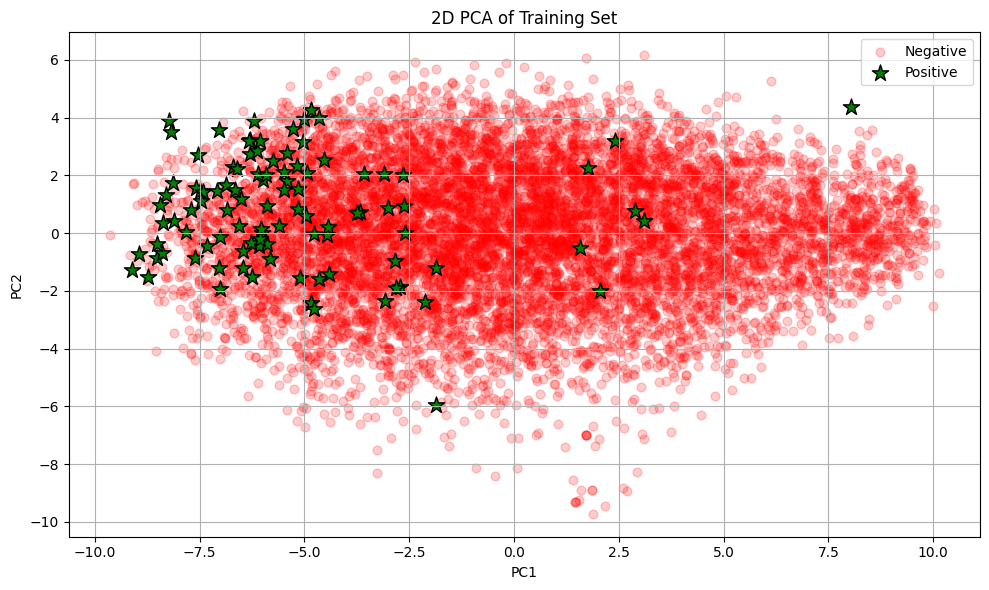

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter 2D
#(-)
plt.scatter(X_train_pca[y_train == False, 0], X_train_pca[y_train == False, 1],
            color='red', marker='o', s=40, alpha=0.2, label='Negative')

#(+)
plt.scatter(X_train_pca[y_train == True, 0], X_train_pca[y_train == True, 1],
            color='green', marker='*', s=150, edgecolor='black', label='Positive')

plt.title("2D PCA of Training Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

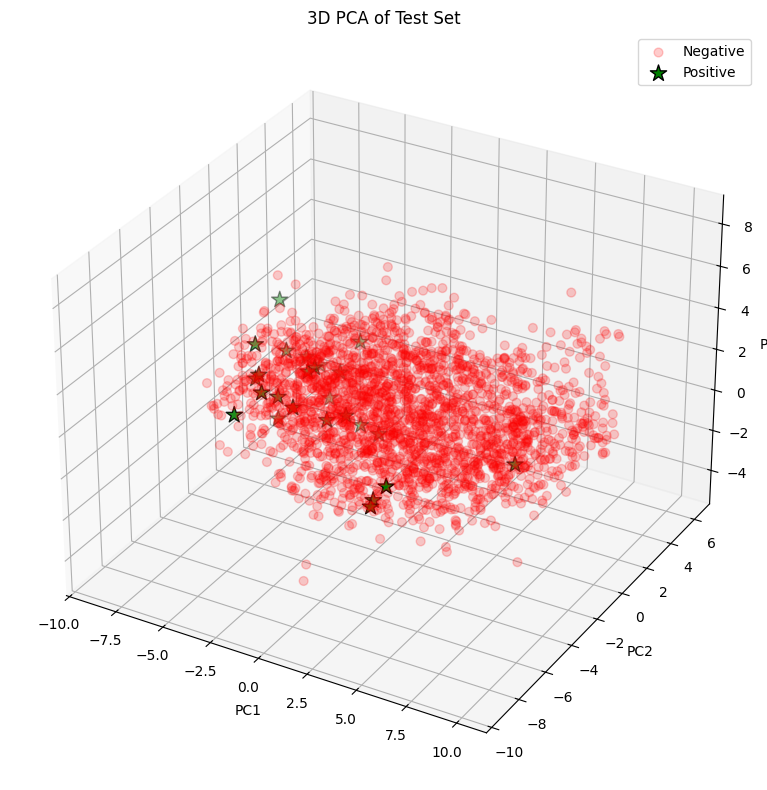

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D
ax.scatter(X_test_pca[y_test == False, 0], X_test_pca[y_test == False, 1], X_test_pca[y_test == False, 2],
           color='red', marker='o', s=40, alpha=0.2, label='Negative')

ax.scatter(X_test_pca[y_test == True, 0], X_test_pca[y_test == True, 1], X_test_pca[y_test == True, 2],
           color='green', marker='*', s=150, edgecolor='black', label='Positive')

ax.set_title("3D PCA of Test Set")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()

## Interactive Graphics

In [ ]:
! pip install plotly

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

# Negativi
fig.add_trace(go.Scatter(
    x=X_train_pca[y_train == False, 0],
    y=X_train_pca[y_train == False, 1],
    mode='markers',
    name='Negative',
    marker=dict(
        symbol='circle',
        color='red',
        size=5,
        opacity=0.2
    ),
    hoverinfo='skip'
))

# Positivi
fig.add_trace(go.Scatter(
    x=X_train_pca[y_train == True, 0],
    y=X_train_pca[y_train == True, 1],
    mode='markers',
    name='Positive',
    marker=dict(
        symbol='star',
        color='green',
        size=15,
        line=dict(color='black', width=1),
        opacity=1.0
    ),
    hoverinfo='skip'
))

fig.update_layout(
    title="2D PCA of Training Set (Selective Transparency)",
    xaxis_title="PC1",
    yaxis_title="PC2",
    legend=dict(itemsizing='constant'),
    width=800,
    height=600
)

fig.show()


# Probability Density Functions $f_{(+)}(x,y)$ $f_{(-)}(x,y)$

We try to estimate the probability density function of positive points within the PCA plan.

As can be seen in previous chapters, reducing by PCA, it's evident that there is a region of the graph having high concentration of positives, while negatives seems to be (bivariate) normally distributed.



In [50]:
from scipy.stats import norm, multivariate_normal
def fit_marginal_normal(data):
    mu, sigma = norm.fit(data)
    return mu, sigma

def fit_multivariate_normal(data):
    mu = np.mean(data, axis=0)
    cov = np.cov(data.T)
    return mu, cov

In [51]:
def plot_distribution(data, mu, sigma, title, xlabel):

    # Real Distribution
    count, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue',
                               edgecolor='black')

    # Valori continui per la PDF teorica
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf = norm.pdf(x_vals, loc=mu, scale=sigma)

    # Plot della distribuzione teorica
    plt.plot(x_vals, pdf, 'r--', label=f'N({mu:.2f}, {sigma:.2f})')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f'$f_-({xlabel})$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pdf


In [52]:
def plot_bivariate_heatmap(mu, cov, data, title, show_points=True):
    """
    Heatmap della distribuzione normale bivariata stimata, con opzione per mostrare o nascondere i punti.

    :param mu: array-like, media della distribuzione (2 elementi)
    :param cov: array-like, matrice di covarianza 2x2
    :param data: numpy array di shape (n_samples, 2)
    :param title: str, titolo del grafico
    :param show_points: bool, se True mostra i punti scatter
    """
    x, y = np.mgrid[
        min(data[:, 0]):max(data[:, 0]):100j,
        min(data[:, 1]):max(data[:, 1]):100j
    ]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean=mu, cov=cov)
    z = rv.pdf(pos)

    plt.figure(figsize=(6, 5))
    contour = plt.contourf(x, y, z, levels=50, cmap='viridis')

    if show_points:
        plt.scatter(data[:, 0], data[:, 1],
                    alpha=0.4, s=10, color='white', edgecolor='black', linewidth=0.5)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(contour, label='Density')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [53]:
from mpl_toolkits.mplot3d import Axes3D

def plot_bivariate_3d(mu, cov, data, title):
    """
    Plot 3D superficie della PDF stimata.
    """
    x, y = np.mgrid[
        min(data[:, 0]):max(data[:, 0]):100j,
        min(data[:, 1]):max(data[:, 1]):100j
    ]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean=mu, cov=cov)
    z = rv.pdf(pos)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("f")
    plt.tight_layout()
    plt.show()


In [54]:
def plot_dual_bivariate_heatmap(
    data_neg, data_pos,
    mu_neg, cov_neg,
    mu_pos, cov_pos,
    title="Bivariate (+) vs (-)",
    show_points=True
):
    plt.style.use('default')
    plt.figure(figsize=(6, 5))

    # Griglia combinata
    x_min = min(data_neg[:, 0].min(), data_pos[:, 0].min())
    x_max = max(data_neg[:, 0].max(), data_pos[:, 0].max())
    y_min = min(data_neg[:, 1].min(), data_pos[:, 1].min())
    y_max = max(data_neg[:, 1].max(), data_pos[:, 1].max())

    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    pos = np.dstack((x, y))

    # Distribuzioni
    rv_neg = multivariate_normal(mean=mu_neg, cov=cov_neg)
    rv_pos = multivariate_normal(mean=mu_pos, cov=cov_pos)
    z_neg = rv_neg.pdf(pos)
    z_pos = rv_pos.pdf(pos)

    # Livelli comuni
    max_density = max(z_neg.max(), z_pos.max())
    levels = np.linspace(0, max_density, 20)

    # Contourf trasparenti
    plt.contourf(x, y, z_neg, levels=levels, cmap='Reds', alpha=0.4, zorder=1)
    plt.contourf(x, y, z_pos, levels=levels, cmap='Greens', alpha=0.4, zorder=2)

    # Punti reali (opzionali)
    if show_points:
        plt.scatter(data_pos[:, 0], data_pos[:, 1], color='green', s=40, marker='*', edgecolor='black', label='(+)', zorder=4)
        plt.scatter(data_neg[:, 0], data_neg[:, 1], color='red', s=10, alpha=0.3, label='(-)', zorder=3)

    # Etichette e layout
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [55]:
def plot_dual_bivariate_surface(
    data_neg, data_pos,
    mu_neg, cov_neg,
    mu_pos, cov_pos,
    title="Bivariate Density Curves (+) vs (-)"
):
    plt.style.use('default')
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Griglia combinata
    x_min = min(data_neg[:, 0].min(), data_pos[:, 0].min())
    x_max = max(data_neg[:, 0].max(), data_pos[:, 0].max())
    y_min = min(data_neg[:, 1].min(), data_pos[:, 1].min())
    y_max = max(data_neg[:, 1].max(), data_pos[:, 1].max())

    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    pos = np.dstack((x, y))

    # Distribuzioni
    rv_neg = multivariate_normal(mean=mu_neg, cov=cov_neg)
    rv_pos = multivariate_normal(mean=mu_pos, cov=cov_pos)
    z_neg = rv_neg.pdf(pos)
    z_pos = rv_pos.pdf(pos)

    # Curve wireframe
    ax.plot_wireframe(x, y, z_neg, rstride=5, cstride=5, color='red', label='(-)', alpha=0.7)
    ax.plot_wireframe(x, y, z_pos, rstride=5, cstride=5, color='green', label='(+)', alpha=0.7)

    # Etichette
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Densità")
    ax.set_title(title)
    ax.view_init(elev=30, azim=135)

    # Legenda 3D "finta" usando linee
    red_line = plt.Line2D([0], [0], linestyle="none", marker='s', color='red', label='(-)')
    green_line = plt.Line2D([0], [0], linestyle="none", marker='s', color='green', label='(+)')
    ax.legend(handles=[red_line, green_line], loc='upper left')

    plt.tight_layout()
    plt.show()

## $f_{-}(x,y,z)$

L'assunzione di normalità sembra essere confermata dai grafici: i punti negativi possono essere considerati distribuiti normalmente sul piano individuato dalla PCA.

Questo, per noi, significa modellare i (-) come rumore gaussiano.

In [56]:
train_negatives = X_train_pca[np.array(y_train) == False]
mu_neg, varcov_neg = fit_multivariate_normal(train_negatives)

In [57]:
mu_neg

array([ 0.05605493, -0.00831359,  0.01174882], dtype=float32)

In [58]:
varcov_neg

array([[ 1.73373993e+01,  4.49518835e-02, -5.80944039e-02],
       [ 4.49518835e-02,  5.11364044e+00,  3.95490758e-03],
       [-5.80944039e-02,  3.95490758e-03,  3.56301675e+00]])

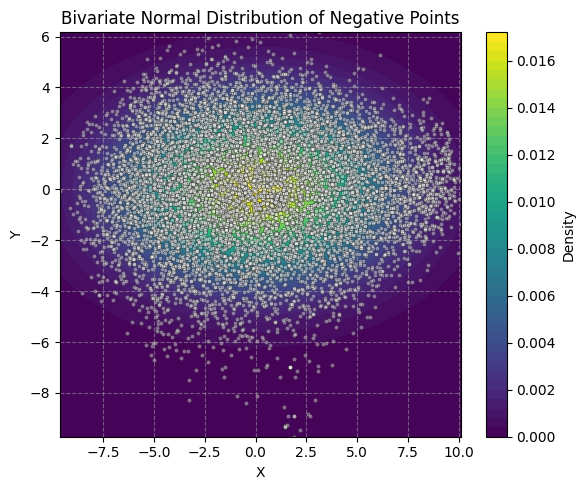

In [59]:
# We do only consider x,y
plot_bivariate_heatmap(mu_neg[:2], varcov_neg[:2, :2], train_negatives, "Bivariate Normal Distribution of Negative Points",show_points = True)

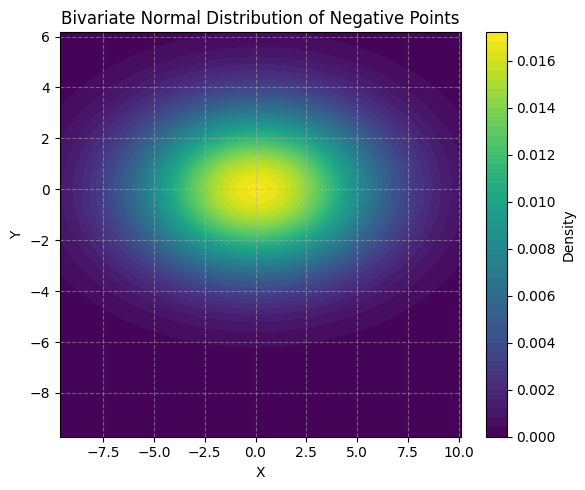

In [ ]:
# We do only consider x,y
plot_bivariate_heatmap(mu_neg[:2], varcov_neg[:2, :2], train_negatives, "Bivariate Normal Distribution of Negative Points",show_points = False)

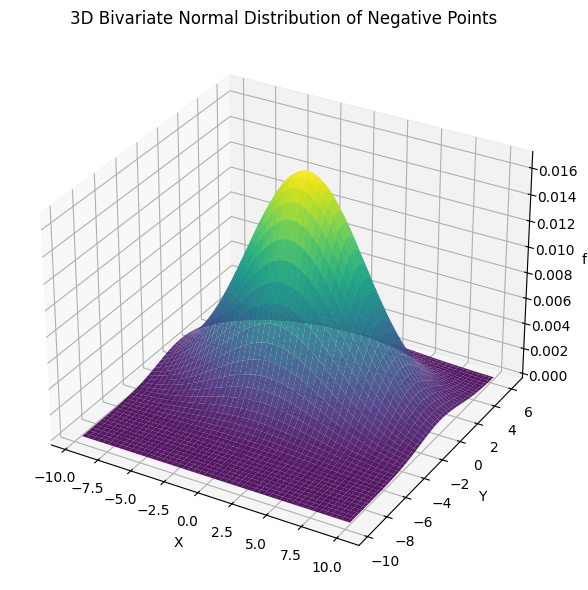

In [ ]:
plot_bivariate_3d(mu_neg[:2], varcov_neg[:2, :2], train_negatives, "3D Bivariate Normal Distribution of Negative Points")

### Marginal of x $f_{-}(x)$

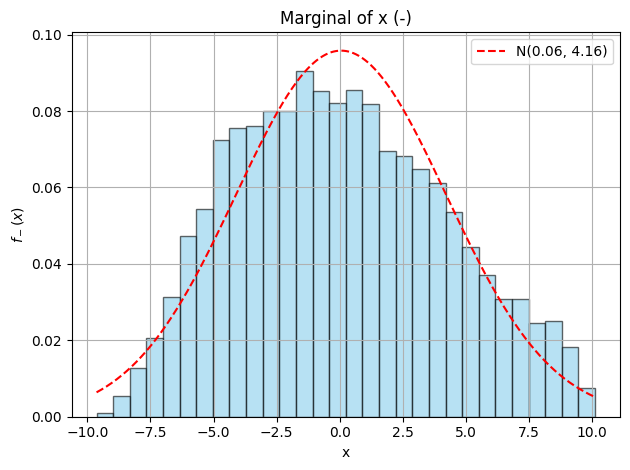

In [60]:
# Plot
pdf_neg_x = plot_distribution(train_negatives[:, 0], mu_neg[0], np.sqrt(varcov_neg[0][0]), "Marginal of x (-)", "x")

### Marginal of y $f_{-}(y)$

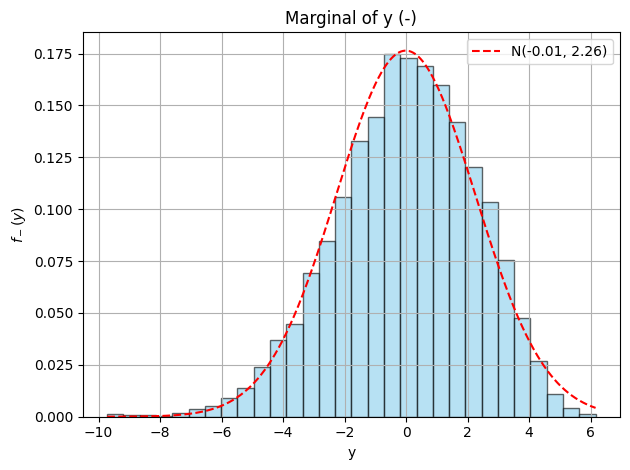

In [ ]:
# Plot
pdf_neg_y = plot_distribution(train_negatives[:, 1], mu_neg[1], np.sqrt(varcov_neg[1][1]), "Marginal of y (-)", "y")

### Marginal of z $f_{-}(z)$

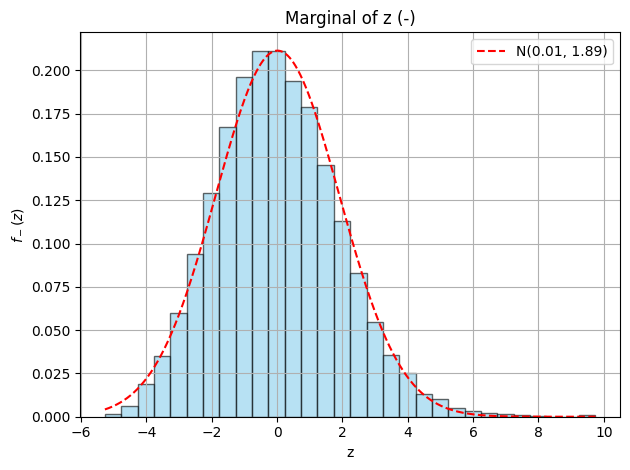

In [ ]:
# Plot
pdf_neg_z = plot_distribution(train_negatives[:, 2], mu_neg[2], np.sqrt(varcov_neg[2][2]), "Marginal of z (-)", "z")

## $f_+(x,y,z) $
L'assuzione di normalità sembra essere ok ma leggermente meno robusta:
- x non sembra seguirla
- y e z invece si, e bene.

In [ ]:
train_positives = X_train_pca[y_train == True]
mu_pos, varcov_pos = fit_bivariate_normal(train_positives)

In [ ]:
mu_pos

array([-5.2293286 ,  0.77554697, -1.0960753 ], dtype=float32)

In [ ]:
varcov_pos

array([[ 8.47779251, -0.09458946, -0.37831956],
       [-0.09458946,  3.59029858,  0.49536416],
       [-0.37831956,  0.49536416,  2.23935751]])

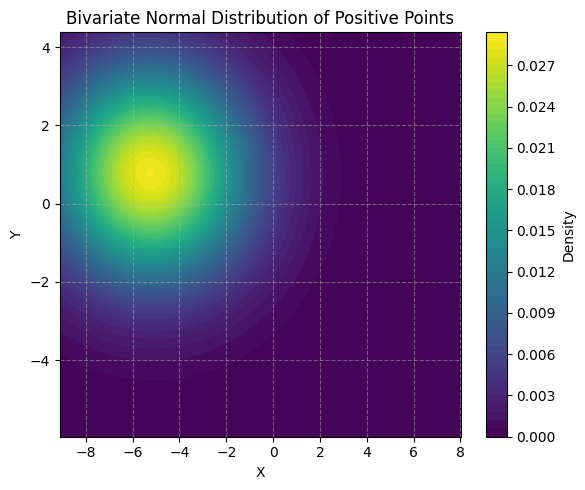

In [ ]:
# We do only consider x,y
plot_bivariate_heatmap(mu_pos[:2], varcov_pos[:2, :2], train_positives, "Bivariate Normal Distribution of Positive Points",show_points = False)

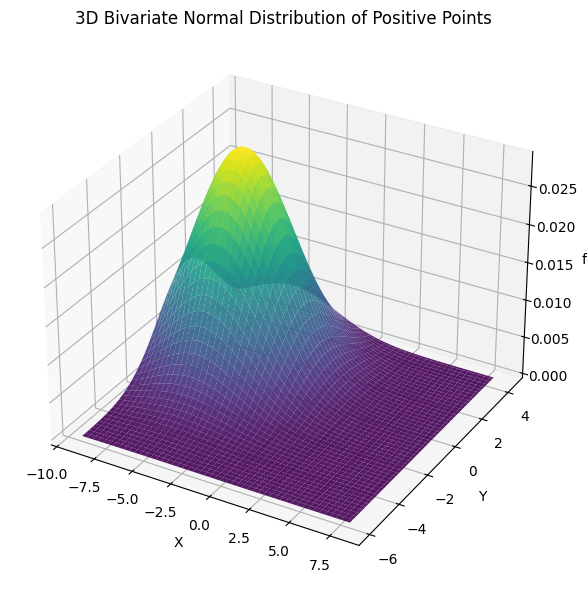

In [ ]:
plot_bivariate_3d(mu_pos[:2], varcov_pos[:2, :2], train_positives, "3D Bivariate Normal Distribution of Positive Points")

### Marginal of x $f_+(x)$

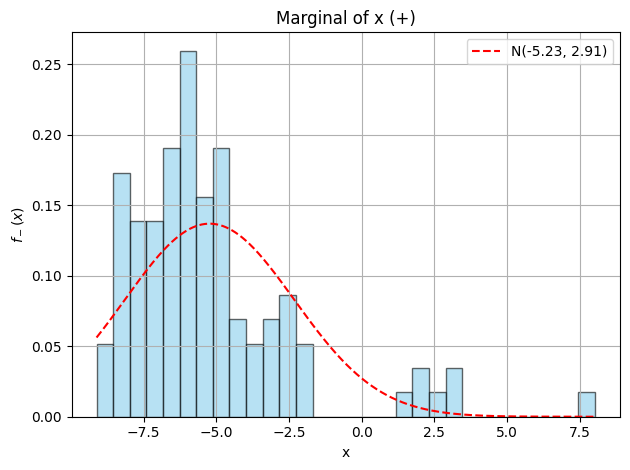

In [ ]:
pdf_pos_x = plot_distribution(train_positives[:, 0], mu_pos[0], np.sqrt(varcov_pos[0][0]), "Marginal of x (+)", "x")

### Marginal of y $f_+(y)$

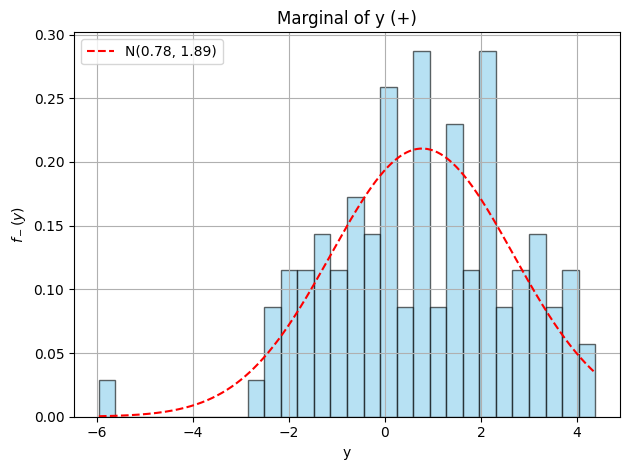

In [ ]:
pdf_pos_z = plot_distribution(train_positives[:, 1], mu_pos[1], np.sqrt(varcov_pos[1][1]), "Marginal of y (+)", "y")

### Marginal of z $f_+(z)$

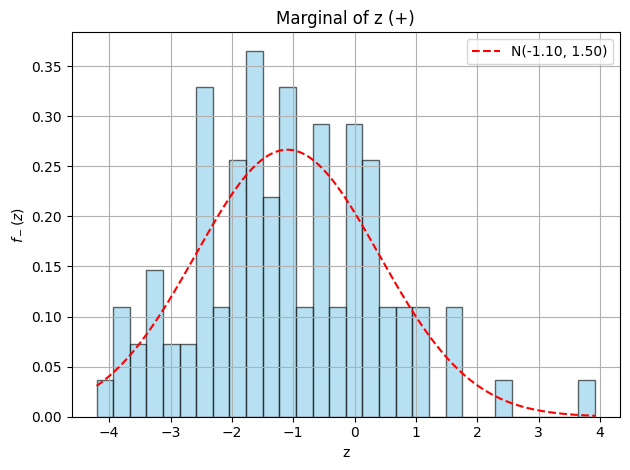

In [ ]:
pdf_pos_z = plot_distribution(train_positives[:, 2], mu_pos[2], np.sqrt(varcov_pos[2][2]), "Marginal of z (+)", "z")

## $f_+$ vs $f_-$

<ipython-input-199-4df920701193>:43: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



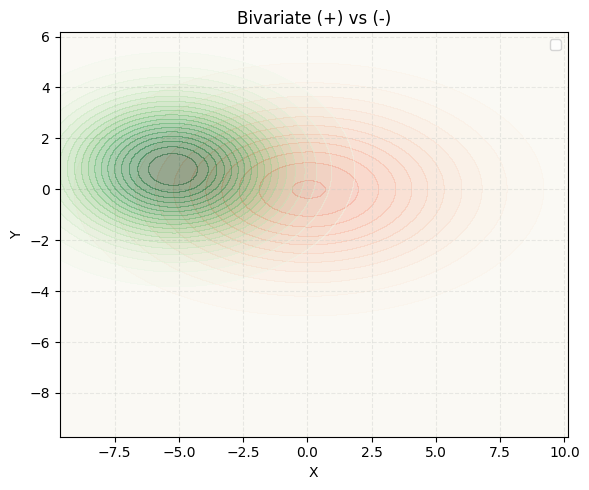

In [ ]:
plot_dual_bivariate_heatmap(train_negatives[:,:2], train_positives[:,:2], mu_neg[:2], varcov_neg[:2,:2], mu_pos[:2], varcov_pos[:2,:2], show_points=False)

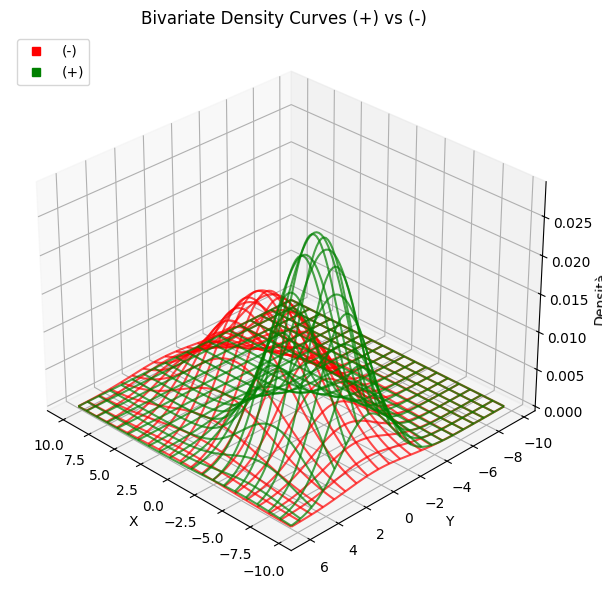

In [ ]:
plot_dual_bivariate_surface(train_negatives[:,:2], train_positives[:,:2], mu_neg[:2], varcov_neg[:2,:2], mu_pos[:2], varcov_pos[:2,:2])

# Bayesian Classifier

In [24]:
def bayes_classifier(X, mu_pos, cov_pos, mu_neg, cov_neg, prior_pos=0.5, prior_neg=0.5):

    # p(x|C+): density of x if generated through C+
    p_x_given_pos = multivariate_normal.pdf(X, mean=mu_pos, cov=cov_pos)

    # p(x|C-): density of x if generated through C-
    p_x_given_neg = multivariate_normal.pdf(X, mean=mu_neg, cov=cov_neg)

    # BAYES P(C+|x) = p(x|C+)P(C+)/p(x) probability of x to belogn to C+
    posterior_pos = p_x_given_pos * prior_pos

    # BAYES P(C-|x) = p(x|C-)p(C-) probability of x to belong to C-
    posterior_neg = p_x_given_neg * prior_neg

    # P(C-|x) + P(C+|x) = 1
    # p(x) = p(x|C+)p(C+) + p(x|C-)P(C-)

    y_pred = posterior_pos > posterior_neg
    return y_pred.astype(int), posterior_pos / (posterior_pos + posterior_neg)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal

def evaluate_bayesian_classifier(
    X_test_pca,
    y_test,
    mu_pos, cov_pos,
    mu_neg, cov_neg,
    prior_pos=0.5,
    prior_neg=0.5,
    use_dims=2  # numero di componenti PCA da usare (default: 2)
):
    # Taglia i dati alle dimensioni richieste
    X_sub = X_test_pca[:, :use_dims]
    mu_pos_sub = mu_pos[:use_dims]
    mu_neg_sub = mu_neg[:use_dims]
    cov_pos_sub = cov_pos[:use_dims, :use_dims]
    cov_neg_sub = cov_neg[:use_dims, :use_dims]

    # Classificazione bayesiana
    p_x_given_pos = multivariate_normal.pdf(X_sub, mean=mu_pos_sub, cov=cov_pos_sub)
    p_x_given_neg = multivariate_normal.pdf(X_sub, mean=mu_neg_sub, cov=cov_neg_sub)

    posterior_pos = p_x_given_pos * prior_pos
    posterior_neg = p_x_given_neg * prior_neg

    y_pred = (posterior_pos > posterior_neg).astype(int)
    posterior_probs = posterior_pos / (posterior_pos + posterior_neg)

    # Costruzione DataFrame dei risultati
    df_results = pd.DataFrame({
        'PC1': X_test_pca[:, 0],
        'PC2': X_test_pca[:, 1],
        'PC3': X_test_pca[:, 2],
        'y_true': y_test.astype(int),
        'y_pred': y_pred,
        'P(C+|x)': posterior_probs
    })

    # Confusion Matrix
    cm = confusion_matrix(df_results['y_true'], df_results['y_pred'])
    cm_df = pd.DataFrame(cm, index=['-', '+'], columns=['-', '+'])

    return df_results, cm_df


In [ ]:
# L'assunzione giusta secondo me è questa: un punto può essere ( a priori) egualmente positivo o negativo
# Il fatto che abbiamo più negativi è un problema simile a quello del survivorship bias.
p_pos = 50; p_neg=50
df, cfm = evaluate_bayesian_classifier(X_test_pca,y_test,mu_pos,varcov_pos,mu_neg,varcov_neg,prior_neg=p_neg,prior_pos=p_pos,use_dims=2)
cfm

,-,+
-,1659,697
+,4,21


In [ ]:
# Il problema che abbiamo è esattamente questo: abbiamo raccolto male. Troppi -, Pochissimi +! Altrimenti, il limite è della tecnologia (non funziona la patch)
p_pos = (y_train==True).sum() / y_train.shape[0]; p_neg= 1 - p_pos
df, cfm = evaluate_bayesian_classifier(X_test_pca,y_test,mu_pos,varcov_pos,mu_neg,varcov_neg,prior_neg=p_neg,prior_pos=p_pos,use_dims=2)
cfm

,-,+
-,2356,0
+,25,0


In [ ]:
# Aggiungere una dimensione migliora le cose!
p_pos = 50; p_neg=50
df, cfm = evaluate_bayesian_classifier(X_test_pca,y_test,mu_pos,varcov_pos,mu_neg,varcov_neg,prior_neg=p_neg,prior_pos=p_pos,use_dims=3)
cfm

,-,+
-,1737,619
+,2,23


### Number of PCA components

In [65]:
# Proviamo ad aggiungere altre dimensioni e vediamo fino a dove arriviamo.

p_pos = 0.5
p_neg = 0.5

pca = PCA(n_components=6)
X_train_pca_B = pca.fit_transform(X_train)
X_test_pca_B = pca.transform(X_test)
mu_pos_B, varcov_pos_B = fit_multivariate_normal(X_train_pca_B[y_train == True])
mu_neg_B, varcov_neg_B = fit_multivariate_normal(X_train_pca_B[y_train == False])
df_B_ncomp4, cfm_B_ncomp4 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=4)
df_B_ncomp5, cfm_B_ncomp5 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=5)
df_B_ncomp6, cfm_B_ncomp6 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=6)

# Explained variance
explained_variance_B = pca.explained_variance_ratio_
cumulative_variance_B = np.cumsum(explained_variance_B)

# Create the table
df_variance_B = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance_B))],
    'Explained Variance (%)': explained_variance_B * 100,
    'Cumulative Variance (%)': cumulative_variance_B * 100
})

df_variance_B

,Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,39.112034,39.112034
1,PC2,11.383082,50.495117
2,PC3,7.943927,58.439045
3,PC4,4.277779,62.716824
4,PC5,3.348840,66.065666
5,PC6,3.003844,69.069504


In [69]:
pca = PCA(n_components=20)
X_train_pca_B = pca.fit_transform(X_train)
X_test_pca_B = pca.transform(X_test)

In [66]:
cfm_B_ncomp4

,-,+
-,1790,566
+,3,22


In [67]:
cfm_B_ncomp5

,-,+
-,1935,421
+,2,23


In [68]:
cfm_B_ncomp6

,-,+
-,1960,396
+,3,22


In [71]:
# Explained variance
explained_variance_B = pca.explained_variance_ratio_
cumulative_variance_B = np.cumsum(explained_variance_B)

# Create the table
df_variance_B = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance_B))],
    'Explained Variance (%)': explained_variance_B * 100,
    'Cumulative Variance (%)': cumulative_variance_B * 100
})

df_variance_B

,Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,39.112034,39.112034
1,PC2,11.383082,50.495117
2,PC3,7.943927,58.439045
3,PC4,4.277779,62.716824
4,PC5,3.348840,66.065666
5,PC6,3.003844,69.069504
6,PC7,2.610551,71.680054
7,PC8,2.062960,73.743019
8,PC9,1.988300,75.731316
9,PC10,1.756541,77.487854


In [73]:
mu_pos_B, varcov_pos_B = fit_multivariate_normal(X_train_pca_B[y_train == True])
mu_neg_B, varcov_neg_B = fit_multivariate_normal(X_train_pca_B[y_train == False])
df_B_ncomp20, cfm_B_ncomp20 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=20)
cfm_B_ncomp20

,-,+
-,2151,205
+,7,18


# Bayesian Retriever

Questo tipo di retriever:
- funziona bene per i positivi
- funziona un pò male per i negativi

Il problema è che il ruolo della distanza viene rilegato soltanto a scegliere QUALI positivi e QUALI negativi ritornare, perdendo il suo ruolo decisionale sul QUANTI di ciascun gruppo selezionare.

Facendo salire k così, se il punto si trova in una zona densa di probabilità positiva, vengono presi più positivi anche se molto più distanti dei punti negeativi.

--> Bisogna pensare ad un metodologia meno netta della distribuzione binomiale, che tenga conto anche della distanza di ciascun punto.

In [11]:
%%capture
! pip install faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.0 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sentence_transformers import SentenceTransformer
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

In [13]:
data = pd.read_csv("data_eng.csv")

In [18]:
import faiss

class BayesianRetrievalSystem:
    def __init__(
        self,
        db: pd.DataFrame,
        embedding_model_name: str = 'bert-base-nli-mean-tokens',
        text_col: str = "Summary",
        label_col: str = "Successful",
        n_components: int = 2
    ):
        self.text_col = text_col
        self.label_col = label_col
        self.db = db

        # Load model
        print(f"\n[INFO] Loading embedding model: {embedding_model_name}")
        self.embedding_model = SentenceTransformer(embedding_model_name, trust_remote_code=True)

        # Compute embeddings
        print("[INFO] Computing embeddings...")
        self.embeddings = self.embedding_model.encode(self.db[text_col].tolist(), show_progress_bar=True)
        self.db['embedding'] = list(self.embeddings)

        # PCA
        print(f"[INFO] Applying PCA (n_components={n_components})...")
        self.pca = PCA(n_components=n_components)
        self.embeddings_pca = self.pca.fit_transform(self.embeddings)
        self.db['pca'] = list(self.embeddings_pca)

        # Split by class
        self.db_pos = self.db[self.db[label_col] == True].reset_index(drop=True).copy()
        self.db_neg = self.db[self.db[label_col] == False].reset_index(drop=True).copy()

        # Estimate Gaussian params
        self.mu_pos, self.cov_pos = self._estimate_gaussian(self.db_pos['pca'])
        self.mu_neg, self.cov_neg = self._estimate_gaussian(self.db_neg['pca'])
        self.mu_all, self.cov_all = self._estimate_gaussian(self.db['pca'])

        # Setup FAISS
        self._setup_faiss()

        # Print summary
        self._print_summary(embedding_model_name)

    def _estimate_gaussian(self, vectors):
        array = np.vstack(vectors.to_numpy())
        mu = np.mean(array, axis=0)
        cov = np.cov(array, rowvar=False)
        return mu, cov

    def _setup_faiss(self):
        print("[INFO] Setting up FAISS indexes...")

        # Convert to float32 numpy arrays
        self.embeddings_pos = np.vstack(self.db_pos['embedding'].to_numpy()).astype('float32')
        self.embeddings_neg = np.vstack(self.db_neg['embedding'].to_numpy()).astype('float32')

        # Create FAISS index for dot product
        dim = self.embeddings_pos.shape[1]
        self.index_pos = faiss.IndexFlatIP(dim)
        self.index_neg = faiss.IndexFlatIP(dim)

        # Add data to indexes
        self.index_pos.add(self.embeddings_pos)
        self.index_neg.add(self.embeddings_neg)

    def _print_summary(self, model_name):
        def format_mu_cov(mu, cov):
            return f"\n  mu: {np.round(mu, 3)}\n  sigma: {np.round(np.sqrt(np.diag(cov)), 3)}"

        print("\n======= BayesianRetrievalSystem Summary =======")
        print(f"Model: {model_name}")
        print(f"Total datapoints: {len(self.db)}")
        print(f"Positive examples: {len(self.db_pos)}")
        print(f"Negative examples: {len(self.db_neg)}")
        print("\n[+] Gaussian Parameters:")
        print("All:" + format_mu_cov(self.mu_all, self.cov_all))
        print("Positive:" + format_mu_cov(self.mu_pos, self.cov_pos))
        print("Negative:" + format_mu_cov(self.mu_neg, self.cov_neg))
        print("==============================================\n")

    def _posterior_probabilities(self, pca_query, prior_pos=0.5, prior_neg=0.5):
        p_x_pos = multivariate_normal.pdf(pca_query, mean=self.mu_pos, cov=self.cov_pos)
        p_x_neg = multivariate_normal.pdf(pca_query, mean=self.mu_neg, cov=self.cov_neg)

        numerator_pos = p_x_pos * prior_pos
        numerator_neg = p_x_neg * prior_neg
        total = numerator_pos + numerator_neg

        return pd.Series({
            "p(x|C+)": p_x_pos,
            "p(x|C-)": p_x_neg,
            "p(C+|x)": numerator_pos / total,
            "p(C-|x)": numerator_neg / total
        })

    def bayesian_probabilities(self, query, prior_pos=0.5, prior_neg=0.5):
        query_emb = self.embedding_model.encode([query])
        query_pca = self.pca.transform(query_emb)[0]
        return self._posterior_probabilities(query_pca, prior_pos, prior_neg)

    def retrieve(self, query, top_k, show_bayesian=False, prior_pos=0.5, prior_neg=0.5):
        query_emb = self.embedding_model.encode([query])[0].astype('float32')
        query_pca = self.pca.transform([query_emb])[0]

        # Bayes
        bayes_probs = self._posterior_probabilities(query_pca, prior_pos=prior_pos, prior_neg=prior_neg)
        if show_bayesian:
            print("\n[Bayesian Probabilities for Query]")
            print(bayes_probs)

        # Simula distribuzione binomiale
        n_pos = int(np.random.binomial(top_k, bayes_probs["p(C+|x)"]))
        n_neg = top_k - n_pos

        # FAISS retrieval
        top_pos = pd.DataFrame()
        top_neg = pd.DataFrame()
        if n_pos > 0:
            D_pos, I_pos = self.index_pos.search(np.array([query_emb]), n_pos) # faiss da problemi se k=0, quindi si rende necessaria questa complicazione a livello di codice.
            top_pos = self.db_pos.iloc[I_pos[0]].copy()
            top_pos['dot_product'] = D_pos[0]
        if n_neg > 0:
            D_neg, I_neg = self.index_neg.search(np.array([query_emb]), n_neg)
            top_neg = self.db_neg.iloc[I_neg[0]].copy()
            top_neg['dot_product'] = D_neg[0]

        results = pd.concat([top_pos, top_neg])
        results['P(C+|x)'] = bayes_probs['p(C+|x)']
        return results.sort_values(by='dot_product', ascending=False).reset_index(drop=True)

    def __call__(self, query, top_k, show_bayesian=False):
        return self.retrieve(query, top_k, show_bayesian=show_bayesian)


In [19]:
# Directory setup
RESULTS_DIR = Path("retrieval_results")
RESULTS_DIR.mkdir(exist_ok=True)
TEXT_LOG = RESULTS_DIR / "results.txt"

# Logger
class Logger:
    def __init__(self, filepath):
        self.file = open(filepath, 'w')

    def log(self, text):
        print(text)
        self.file.write(text + '\n')
        self.file.flush()

    def close(self):
        self.file.close()

logger = Logger(TEXT_LOG)


# Stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_vals = [1, 3, 5, 7, 9]

fold = 1
for train_idx, test_idx in skf.split(data['Summary'], data['Successful']):
    logger.log(f"=== Fold {fold} ===")
    train_data = data.iloc[train_idx].reset_index(drop=True)
    test_data = data.iloc[test_idx].reset_index(drop=True)

    system = BayesianRetrievalSystem(train_data)
    y_true_all, y_pred_all = [], []

    # KNN evaluation
    for k in k_vals:
        y_true, y_pred = [], []

        for _, row in test_data.iterrows():
            retrieved = system(row['Summary'], top_k=k, show_bayesian=False)
            pred = retrieved['Successful'].value_counts().idxmax()
            y_true.append(row['Successful'])
            y_pred.append(pred)

        f1 = f1_score(y_true, y_pred, average='macro')
        cm = confusion_matrix(y_true, y_pred)
        logger.log(f"k={k} | F1 Macro: {f1:.4f}")
        logger.log(f"Confusion Matrix:\n{cm}\n")

        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)

    # Precision@k and Presence@k
    for k in k_vals:
        precision_list = []
        presence_list = []

        for _, row in test_data.iterrows():
            if row['Successful'] == False:
                continue
            retrieved = system(row['Summary'], top_k=k, show_bayesian=False)
            rel = retrieved['Successful'].values
            precision =  np.mean(rel) if len(rel) > 0 else 0
            presence = int(np.any(rel))
            precision_list.append(precision)
            presence_list.append(presence)

        precision_avg = np.mean(precision_list)
        presence_avg = np.mean(presence_list)

        logger.log(f"k={k} | Precision@k for +: {precision_avg:.4f} | Presence@k for +: {presence_avg:.4f}")

    fold += 1

logger.close()

=== Fold 1 ===

[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= BayesianRetrievalSystem Summary =======
Model: bert-base-nli-mean-tokens
Total datapoints: 9523
Positive examples: 101
Negative examples: 9422

[+] Gaussian Parameters:
All:
  mu: [0. 0.]
  sigma: [4.186 2.258]
Positive:
  mu: [-5.233  0.674]
  sigma: [2.793 1.88 ]
Negative:
  mu: [ 0.056 -0.007]
  sigma: [4.163 2.261]

k=1 | F1 Macro: 0.4352
Confusion Matrix:
[[1642  714]
 [   6   19]]

k=3 | F1 Macro: 0.4355
Confusion Matrix:
[[1644  712]
 [   6   19]]

k=5 | F1 Macro: 0.4377
Confusion Matrix:
[[1641  715]
 [   4   21]]

k=7 | F1 Macro: 0.4371
Confusion Matrix:
[[1645  711]
 [   5   20]]

k=9 | F1 Macro: 0.4415
Confusion Matrix:
[[1654  702]
 [   3   22]]

k=1 | Precision@k for +: 0.8400 | Presence@k for +: 0.8400
k=3 | Precision@k for +: 0.7467 | Presence@k for +: 0.8800
k=5 | Precision@k for +: 0.7360 | Presence@k for +: 0.9600
k=7 | Precision@k for +: 0.7657 | Presence@k for +: 0.9200
k=9 | Precisi

ValueError: All arrays must be of the same length